# Assignment - 02
## Submitted by - SHIVAM SAHIL (2023aa05663)
## Subject - Video Analytics

In [68]:
# Necessary imports
import cv2
import matplotlib.pyplot as plt
from moviepy.video.io.VideoFileClip import VideoFileClip
import subprocess
import numpy as np
import time
from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector
from skimage.feature import local_binary_pattern
from scipy.signal import convolve2d
from skimage.feature import graycomatrix as greycomatrix, graycoprops as greycoprops
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/shivamsahil/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [73]:
# Common Utilities
def get_video_path(video_type = 'cricket'):
    if(video_type.lower() == 'cricket'):
        return r'sample.mp4'
    return r'sample2.mp4'

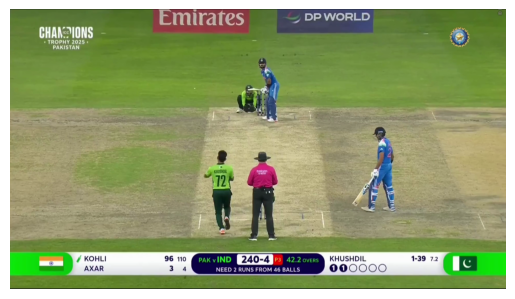

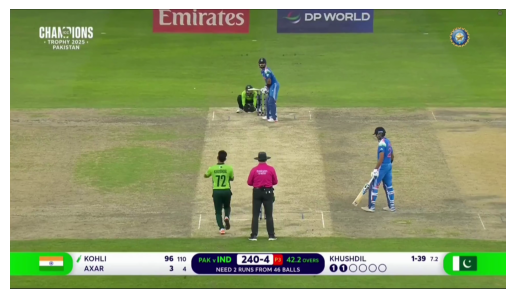

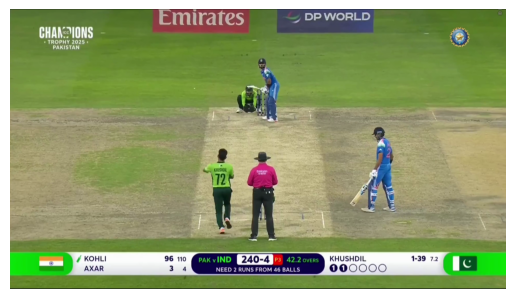

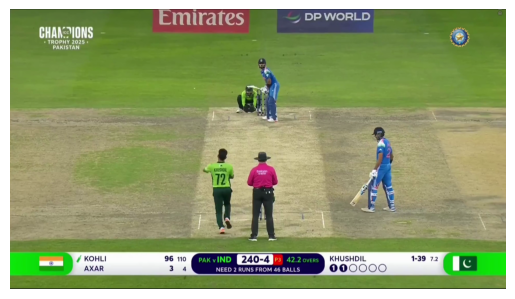

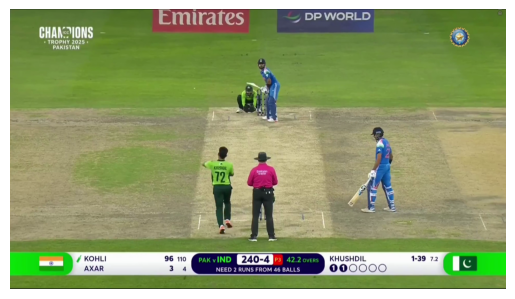

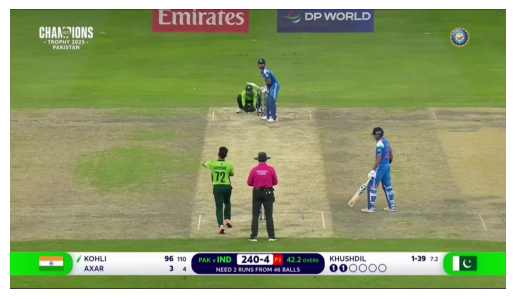

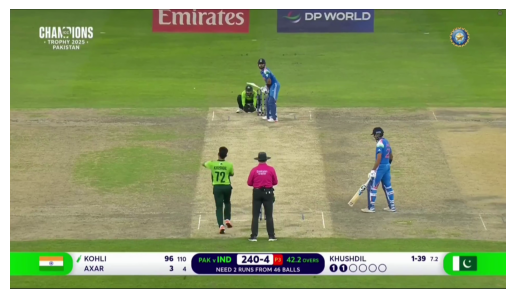

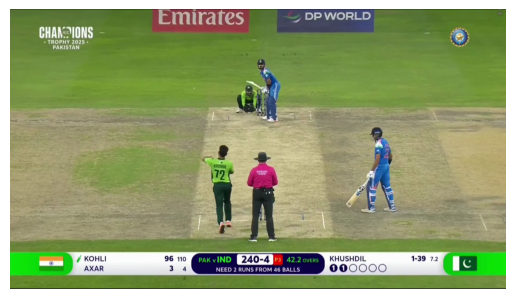

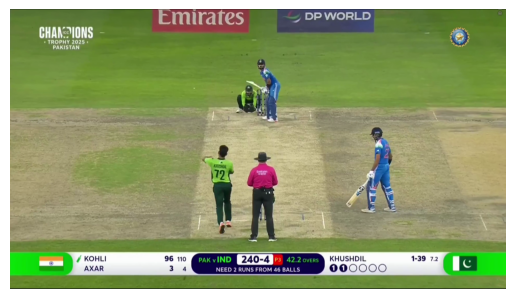

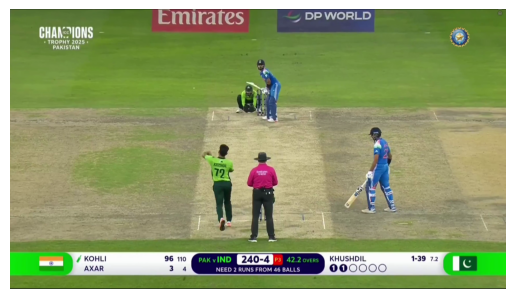

In [5]:
video_path = get_video_path()
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error reading video file")
    exit()
    
frame_count = 0

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Convert frame from BGR to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame using matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    frame_count += 1

    # Break after displaying 10 frames (change this as needed)
    if frame_count == 10:
        break

# Release the video capture object
cap.release()

### Part 2 - Fetching Video Metadata

In [6]:
# Reading Video from Path
video_path = get_video_path()
# Load Video Clip File
video_clip = VideoFileClip(video_path)

# Extract video metadata
duration = video_clip.duration  # Duration of the video (in seconds)
fps = video_clip.fps  # Frames per second
width, height = video_clip.size  # Video dimensions (width x height)

# Display the extracted metadata
print(f"Video Duration: {duration} seconds")
print(f"Frames per Second (FPS): {fps}")
print(f"Video Dimensions: {width} x {height} pixels")


{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [3456, 1950], 'bitrate': 7264, 'fps': 60.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'Core Media Video', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 48000, 'bitrate': 62, 'metadata': {'Metadata': '', 'handler_name': 'Core Media Audio', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 19.9, 'bitrate': 7328, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [3456, 1950], 'video_bitrate': 7264, 'video_fps'

### Processing Video Metadata using ffprobe and sub process

In [7]:
# Command to get video metadata using ffprobe
video_path = get_video_path()
ffprobe_command = f'ffprobe -v error -select_streams v:0 -show_entries stream=height,width,duration,r_frame_rate,bit_rate -of default=noprint_wrappers=1:nokey=1 "{video_path}"'

dur_cmd = f'ffprobe -v error -show_entries format=duration -of default=noprint_wrappers=1:nokey=1 "{video_path}"'

# Execute the command using subprocess.
process = subprocess.Popen(ffprobe_command, shell=True, stdout=subprocess.PIPE,
                           stderr=subprocess.STDOUT)
output, _ = process.communicate()


# Decode and display the extracted metadata
metadata = output.decode('utf-8').split('\n')#''1980'+10=>198010 1980+10=>1990
video_width = int(metadata[1])
video_height = int(metadata[0])
video_duration = eval(metadata[3])
frame_rate = eval(metadata[2])
bit_rate = int(metadata[4])


print(f"Video Duration: {video_duration} seconds")
print(f"Frames per Second (FPS): {frame_rate}")
print(f"Video Dimensions: {video_width} x {video_height} pixels")
print(f"Bitrate: {bit_rate} bps")
print('Metadata ', metadata)

Video Duration: 19.866667 seconds
Frames per Second (FPS): 60.0
Video Dimensions: 1950 x 3456 pixels
Bitrate: 7264397 bps
Metadata  ['3456', '1950', '60/1', '19.866667', '7264397', '']


### Color Histogram Computation

FPS =  60.0
Total Frames =  1192
Length of histogram =  1192


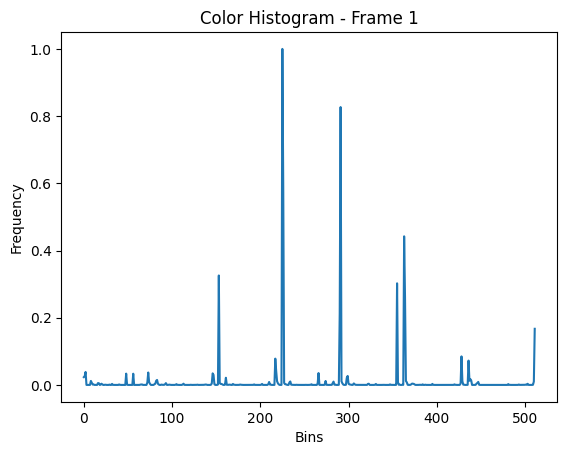

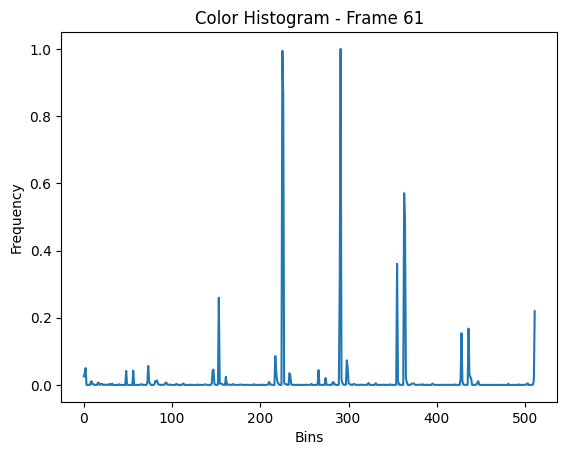

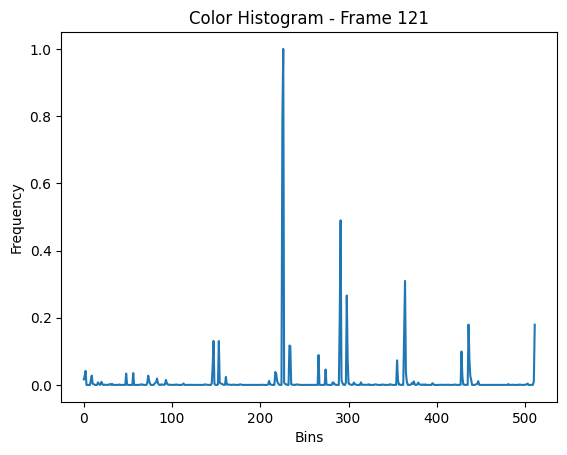

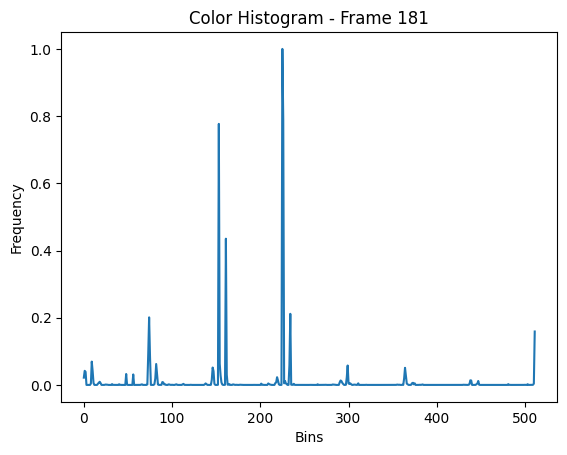

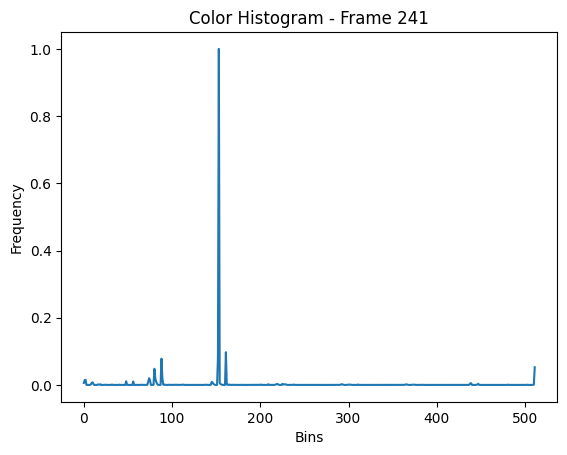

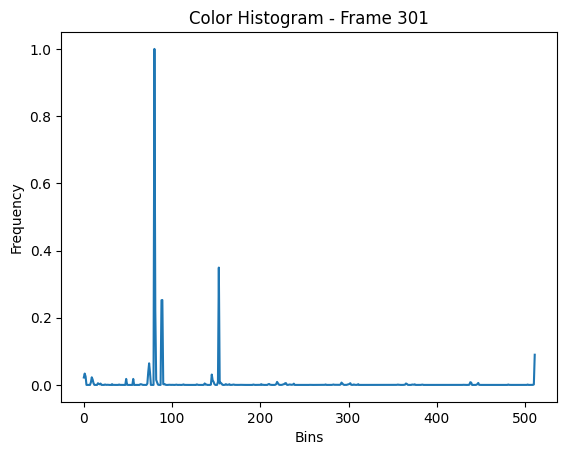

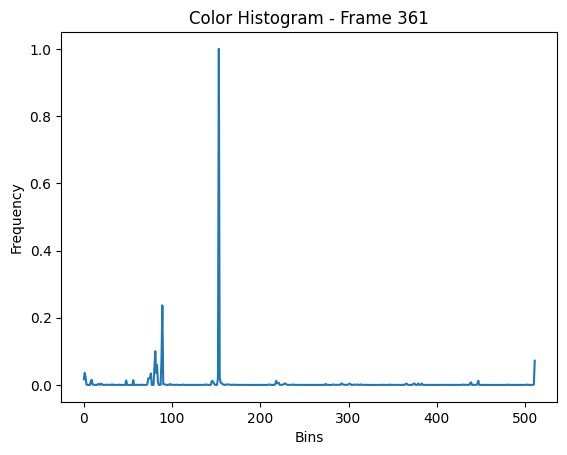

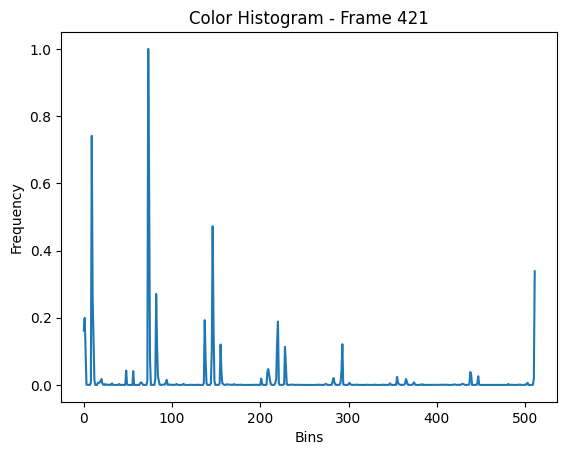

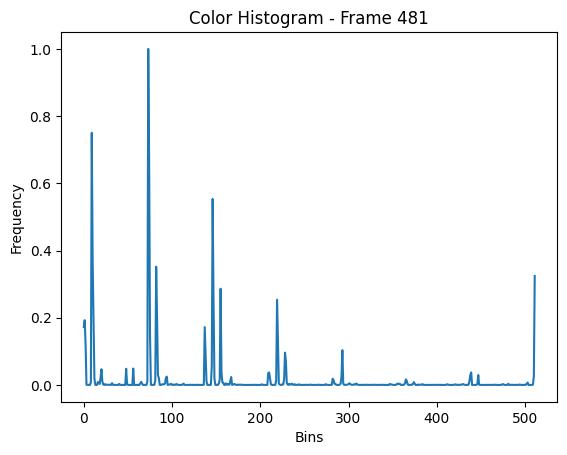

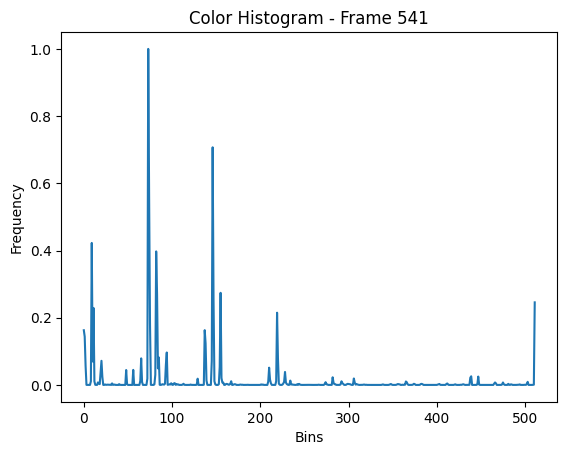

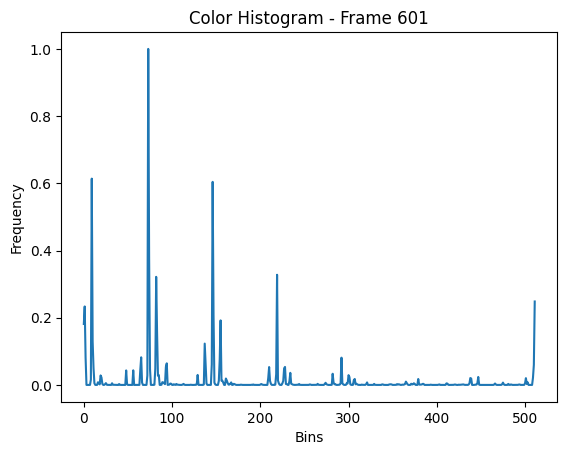

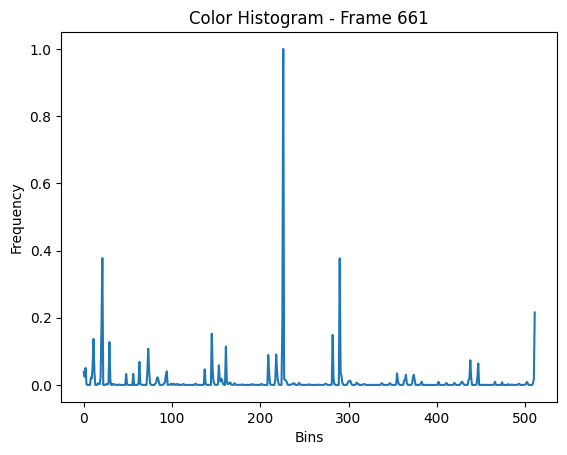

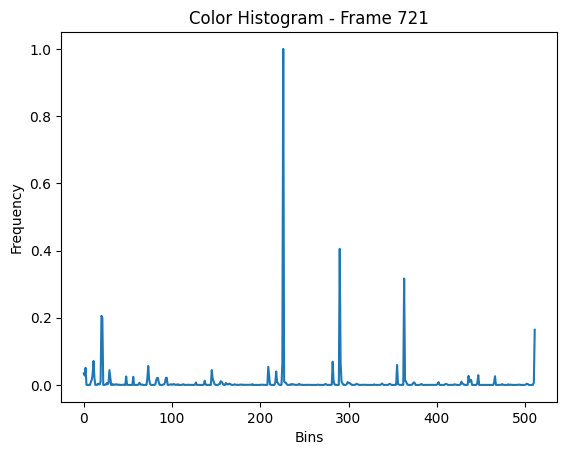

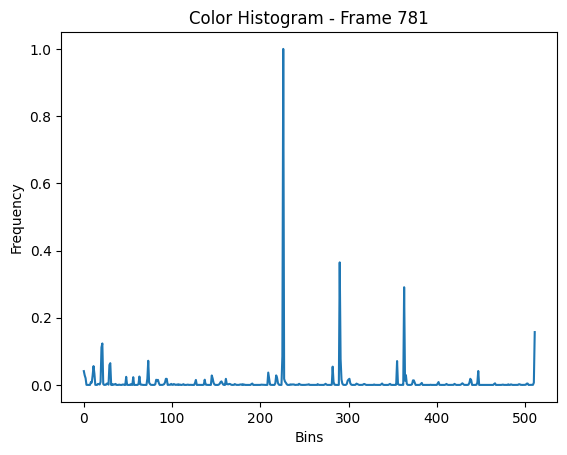

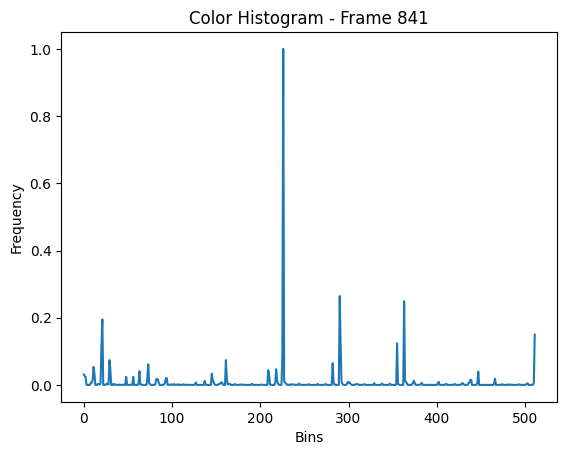

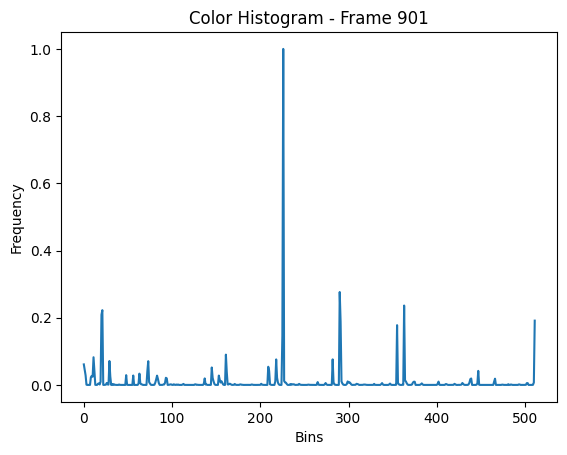

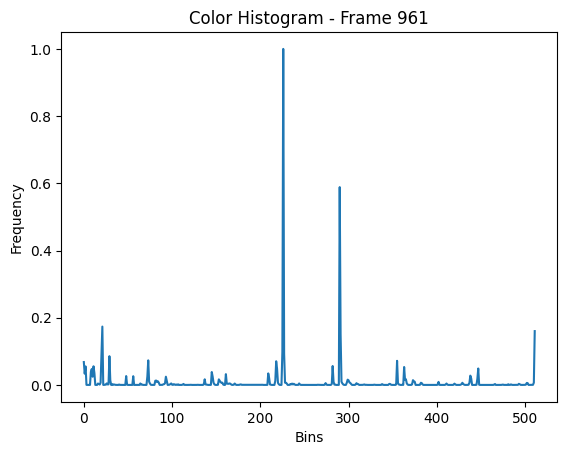

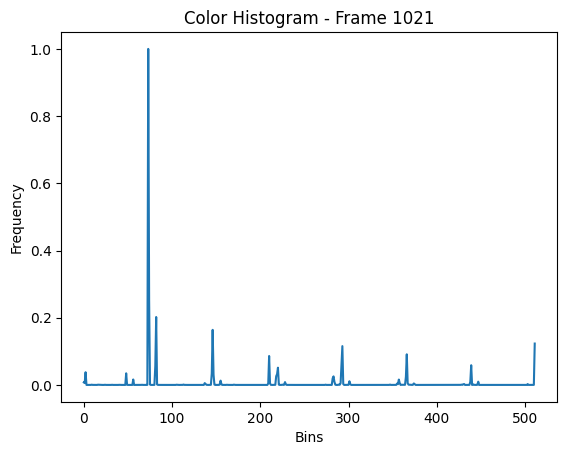

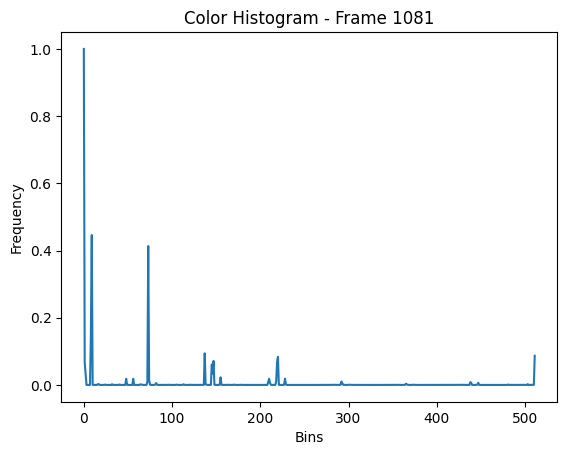

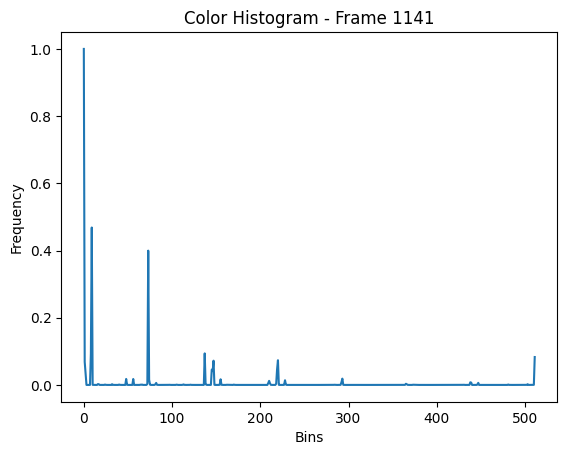

In [8]:
video_path = get_video_path()

def compute_color_histogram(frame):
    # Convert the frame from BGR to RGB color space
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Compute the color histogram
    hist = cv2.calcHist([rgb_frame], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    # Normalize the histogram
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist

# Open the video file
video = cv2.VideoCapture(video_path)

# Get the video frames per second (fps) and total number of frames
fps = video.get(cv2.CAP_PROP_FPS)
print('FPS = ', fps)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print('Total Frames = ', total_frames)

# Calculate the number of frames to process based on the desired duration (30 seconds)
num_frames_to_process = int(fps * 30)

# Initialize a list to store the color histograms for each frame
color_histograms = []

# Process each frame of the video
for i in range(num_frames_to_process):
    ret, frame = video.read()
    if not ret:
        break

    # Compute the color histogram for the current frame
    hist = compute_color_histogram(frame)
    color_histograms.append(hist)

# Release the video capture object
video.release()
print('Length of histogram = ', len(color_histograms))

# Plot the color histogram for each frame
step_size = 60 # Plotting every 60th frame - 20 frames (to step down too many frames display)
for i, hist in enumerate(color_histograms):
    if i % step_size == 0:
        plt.figure()
        plt.title(f'Color Histogram - Frame {i+1}')
        plt.xlabel('Bins')
        plt.ylabel('Frequency')
        plt.plot(hist.flatten())
        plt.show()

FPS =  60.0
Total Frames =  1192
Keyframes =  5


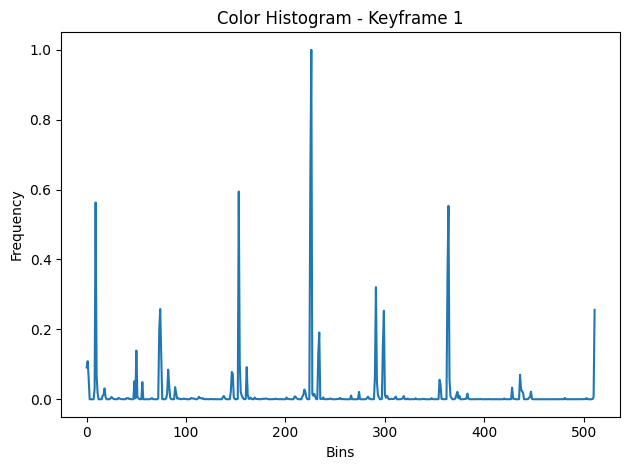

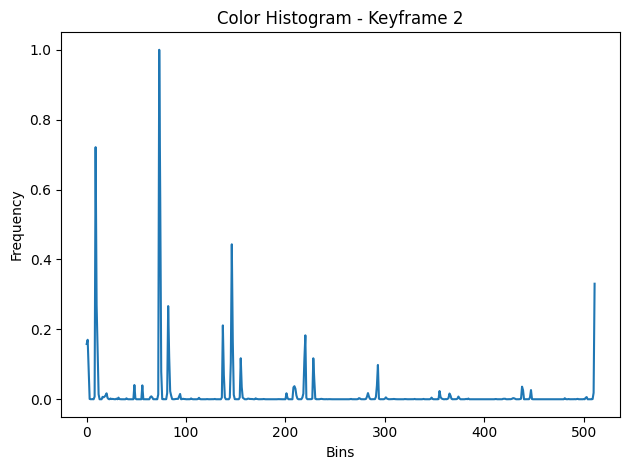

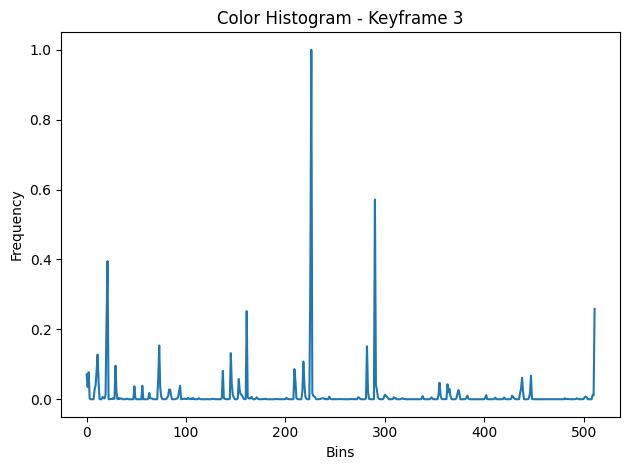

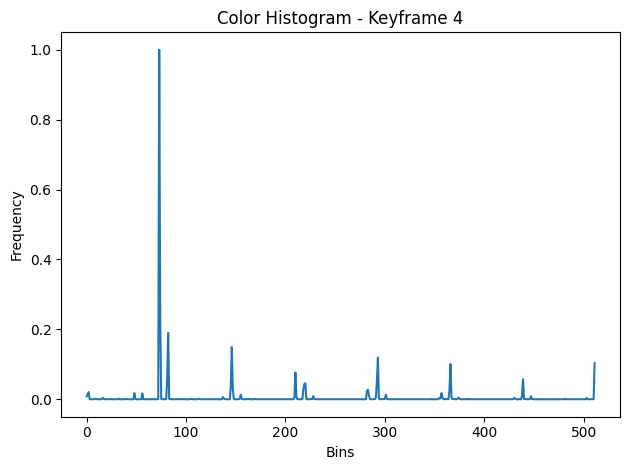

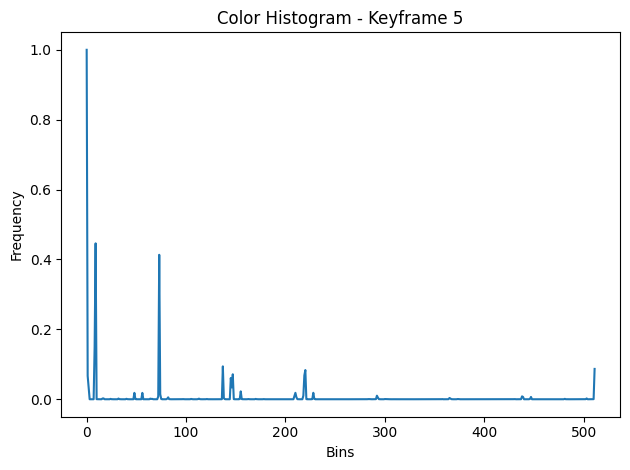

In [9]:
# Set the threshold for scene change detection
threshold = 30

# Initialize variables
prev_frame = None
keyframes = []

video_path = get_video_path()
video = cv2.VideoCapture(video_path)

# Get the video frames per second (fps) and total number of frames
fps = video.get(cv2.CAP_PROP_FPS)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

print('FPS = ', fps)
print('Total Frames = ', total_frames)


# Process each frame of the video
while True:
    ret, frame = video.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Check if the previous frame exists
    if prev_frame is not None:
        # Compute the absolute difference between the current and previous frames
        diff = cv2.absdiff(gray_frame, prev_frame)

        # Compute the mean intensity of the difference
        mean_intensity = np.mean(diff)

        # Check if the mean intensity exceeds the threshold
        if mean_intensity > threshold:
            keyframes.append(frame)

    # Update the previous frame
    prev_frame = gray_frame

# Release the video capture object
video.release()
print('Keyframes = ', len(keyframes))

# Plot the color histogram for each keyframe
for i, keyframe in enumerate(keyframes):
    # Compute the color histogram for the keyframe
    hist = compute_color_histogram(keyframe)

    plt.figure()
    plt.title(f'Color Histogram - Keyframe {i+1}')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.plot(hist.flatten())
    plt.tight_layout()
    plt.show()

FPS = 60.0
Total Frames = 1192
Processed 1192 frames.


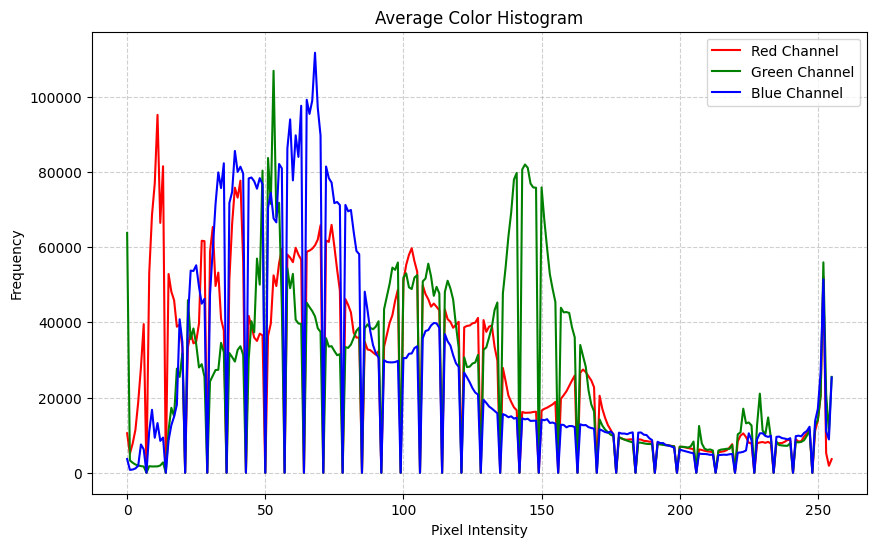

In [10]:
video_path = get_video_path()
video = cv2.VideoCapture(video_path)

def compute_color_histogram(frame):
    # Convert the frame from BGR to RGB color space
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Compute histograms for each channel
    hist_r = cv2.calcHist([rgb_frame], [0], None, [256], [0, 256]).flatten()
    hist_g = cv2.calcHist([rgb_frame], [1], None, [256], [0, 256]).flatten()
    hist_b = cv2.calcHist([rgb_frame], [2], None, [256], [0, 256]).flatten()

    return hist_r, hist_g, hist_b

if not video.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the video properties
fps = video.get(cv2.CAP_PROP_FPS)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'FPS = {fps}')
print(f'Total Frames = {total_frames}')

# Number of frames to process (e.g., 30 seconds of video)
num_frames_to_process = min(int(fps * 30), total_frames)

# Initialize lists to store histograms
hist_r_list, hist_g_list, hist_b_list = [], [], []

# Process each frame of the video
for i in range(num_frames_to_process):
    ret, frame = video.read()
    if not ret:
        break

    # Compute the color histogram for the current frame
    hist_r, hist_g, hist_b = compute_color_histogram(frame)
    hist_r_list.append(hist_r)
    hist_g_list.append(hist_g)
    hist_b_list.append(hist_b)

# Release the video capture object
video.release()

print(f'Processed {len(hist_r_list)} frames.')

# Plot average color histograms
mean_hist_r = np.mean(hist_r_list, axis=0)
mean_hist_g = np.mean(hist_g_list, axis=0)
mean_hist_b = np.mean(hist_b_list, axis=0)

plt.figure(figsize=(10, 6))
plt.title('Average Color Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.plot(mean_hist_r, color='red', label='Red Channel')
plt.plot(mean_hist_g, color='green', label='Green Channel')
plt.plot(mean_hist_b, color='blue', label='Blue Channel')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Webinar 2 Exercises

### Color Histogram Moment coherence

In [11]:
def extract_keyframes(video_path, threshold=30):
    cap = cv2.VideoCapture(video_path)
    prev_frame = None
    keyframes = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Check if the previous frame exists
        if prev_frame is not None:
            # Compute the absolute difference between the current and previous frames
            diff = cv2.absdiff(gray_frame, prev_frame)

            # Compute the mean intensity of the difference
            mean_intensity = np.mean(diff)

            # Check if the mean intensity exceeds the threshold
            if mean_intensity > threshold:
                keyframes.append(frame)

        # Update the previous frame
        prev_frame = gray_frame
    cap.release()

    return keyframes

def compute_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def compute_color_moment(image):
    moments = []
    for i in range(3):
        channel = image[:, :, i]
        mean = np.mean(channel)
        std_dev = np.std(channel)
        skewness = np.mean(((channel - mean) / std_dev) ** 3)
        moments.extend([mean, std_dev, skewness])
    return np.array(moments)

def compute_color_coherence_vector(image, threshold=5, bins=8, downscale_size=(64, 64)):
    """
    Since my frame resolution is high, this function was talking long. 
    So I did additional things to make it optimized function to compute Color Coherence Vector.
    Here's the steps I performed - 
    - Used downsampling for faster processing.
    - Avodiing slow loops with numpy vectorization.
    - Using binning for faster processing.
    """
    coherence_vector = np.zeros((3, bins, 2))

    for i in range(3):  # Process each channel separately
        channel = cv2.resize(image[:, :, i], downscale_size)  # Downscale for speed
        hist, bin_edges = np.histogram(channel, bins=bins, range=(0, 256))

        # Convert channel to binary image for connected component analysis
        _, binary_img = cv2.threshold(channel, 1, 255, cv2.THRESH_BINARY)

        # Use connected components analysis
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, connectivity=8)

        # Vectorized calculation of coherence
        label_sizes = stats[:, cv2.CC_STAT_AREA][1:]  # Ignore background label (0)

        coherent_pixels = np.sum(label_sizes[label_sizes > threshold])
        incoherent_pixels = np.sum(label_sizes[label_sizes <= threshold])

        coherence_vector[i, :, 0] = coherent_pixels
        coherence_vector[i, :, 1] = incoherent_pixels

    return coherence_vector.flatten()

def display_keyframes_grid(keyframes):
    num_keyframes = len(keyframes)
    num_cols = min(5, num_keyframes)
    num_rows = (num_keyframes + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    fig.suptitle("Scene Boundary Frames", fontsize=16)

    if num_rows == 1:
        axes = np.array([axes])  
    if num_cols == 1:
        axes = axes[:, np.newaxis]  

    for i, frame in enumerate(keyframes):
        row, col = divmod(i, num_cols)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(frame_rgb)
        axes[row, col].axis("off")

    # Hide extra subplots
    for i in range(num_keyframes, num_rows * num_cols):
        row, col = divmod(i, num_cols)
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()
   
def process_frame(frame, idx, total):
    """Compute features for a single frame with logging."""
    print(f'Processing frame {idx+1}/{total}...')

    start = time.time()
    histogram = compute_color_histogram(frame)
    print(f'  Histogram computed in {time.time() - start:.4f}s')

    start = time.time()
    moment = compute_color_moment(frame)
    print(f'  Moment computed in {time.time() - start:.4f}s')

    start = time.time()
    coherence_vector = compute_color_coherence_vector(frame)
    print(f'  Coherence Vector computed in {time.time() - start:.4f}s')

    start = time.time()
    feature_vector = np.concatenate((histogram, moment, coherence_vector))
    print(f'  Feature Vector assembled in {time.time() - start:.4f}s')

    return feature_vector

In [12]:
video_path = get_video_path()
keyframes = extract_keyframes(video_path)
print(f'Total Keyframes: {len(keyframes)}')

feature_vectors = []

for idx, frame in enumerate(keyframes):
    feature_vector = process_frame(frame, idx, len(keyframes))
    feature_vectors.append(feature_vector)


Total Keyframes: 5
Processing frame 1/5...
  Histogram computed in 0.0125s
  Moment computed in 0.2368s
  Coherence Vector computed in 0.0074s
  Feature Vector assembled in 0.0000s
Processing frame 2/5...
  Histogram computed in 0.0125s
  Moment computed in 0.2149s
  Coherence Vector computed in 0.0073s
  Feature Vector assembled in 0.0000s
Processing frame 3/5...
  Histogram computed in 0.0123s
  Moment computed in 0.2121s
  Coherence Vector computed in 0.0072s
  Feature Vector assembled in 0.0000s
Processing frame 4/5...
  Histogram computed in 0.0123s
  Moment computed in 0.2060s
  Coherence Vector computed in 0.0071s
  Feature Vector assembled in 0.0000s
Processing frame 5/5...
  Histogram computed in 0.0123s
  Moment computed in 0.2210s
  Coherence Vector computed in 0.0077s
  Feature Vector assembled in 0.0000s


5


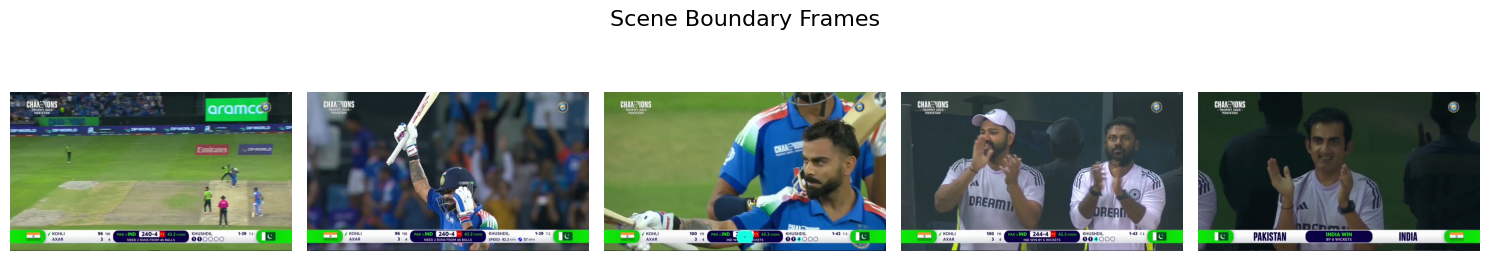

In [13]:
print(len(feature_vectors))
display_keyframes_grid(keyframes)

In [14]:
def detect_shot_boundaries_pyscenedetect(video_path, threshold=30.0):
    # Create a video manager and scene manager
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()

    # Add a content detector with the given threshold
    scene_manager.add_detector(ContentDetector(threshold=threshold))

    # Start the video manager
    video_manager.set_downscale_factor()  # Automatically downscale for faster processing
    video_manager.start()

    # Detect scenes
    scene_manager.detect_scenes(frame_source=video_manager)

    # Get the list of detected scenes
    scene_list = scene_manager.get_scene_list()
    scene_boundaries = [(start.get_frames(), end.get_frames()) for start, end in scene_list]

    print(f"Shot boundaries detected: {scene_boundaries}")
    return scene_boundaries

In [15]:
video_path = get_video_path()
shot_boundaries = detect_shot_boundaries_pyscenedetect(video_path, threshold=30.0)


VideoManager is deprecated and will be removed.


Shot boundaries detected: [(0, 141), (141, 417), (417, 648), (648, 974), (974, 1080), (1080, 1192)]


In [48]:
def detect_shot_boundaries(video_path, threshold=30.0):
    # Initialize the video manager and scene manager
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()

    scene_manager.add_detector(ContentDetector(threshold=threshold))

    video_manager.start()

    scene_manager.detect_scenes(frame_source=video_manager)

    scene_list = scene_manager.get_scene_list()

    print(f"Detected {len(scene_list)} scenes.")
    print("Scene boundaries (frame numbers):")
    for i, (start_time, end_time) in enumerate(scene_list):
        print(f"Scene {i + 1}: Start {start_time.get_frames()}, End {end_time.get_frames()}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    keyframes = []
    for i, (start_time, _) in enumerate(scene_list):
        start_frame = start_time.get_frames()

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame at scene {i + 1}.")
            continue

        keyframes.append(frame)

    cap.release()
    return keyframes

VideoManager is deprecated and will be removed.


Detected 6 scenes.
Scene boundaries (frame numbers):
Scene 1: Start 0, End 141
Scene 2: Start 141, End 417
Scene 3: Start 417, End 648
Scene 4: Start 648, End 974
Scene 5: Start 974, End 1080
Scene 6: Start 1080, End 1192


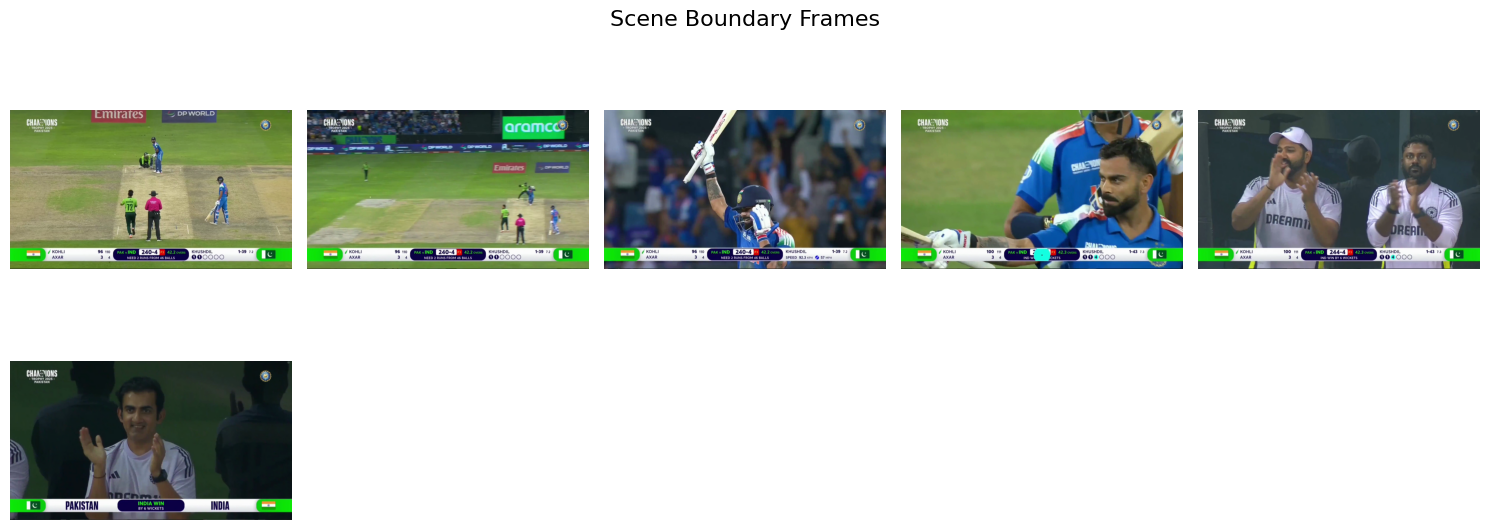

In [49]:
video_path = get_video_path()
keyframes = detect_shot_boundaries(video_path)
display_keyframes_grid(keyframes)

## Object Detection

In [60]:
# Load YOLO model
yolo_weights = r"yolov3.weights"
yolo_cfg = r"yolov3.cfg"  
yolo_classes = r"coco.names"

# Load class labels
with open(yolo_classes, "r") as f:
    classes = f.read().strip().split("\n")

# Load YOLO model
net = cv2.dnn.readNet(yolo_weights, yolo_cfg)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

VideoManager is deprecated and will be removed.


Detected 6 scenes.
Scene boundaries (frame numbers):
Scene 1: Start 0, End 141
Scene 2: Start 141, End 417
Scene 3: Start 417, End 648
Scene 4: Start 648, End 974
Scene 5: Start 974, End 1080
Scene 6: Start 1080, End 1192


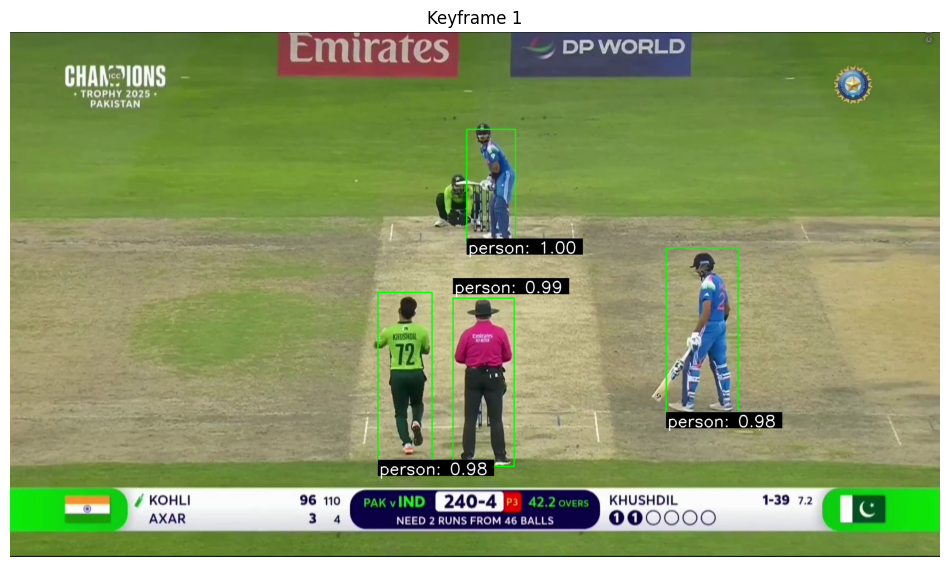

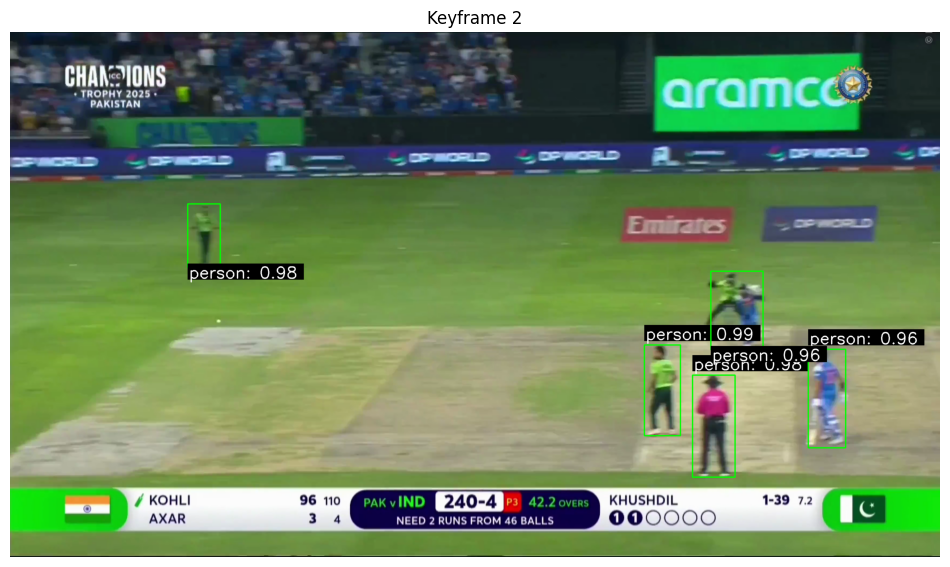

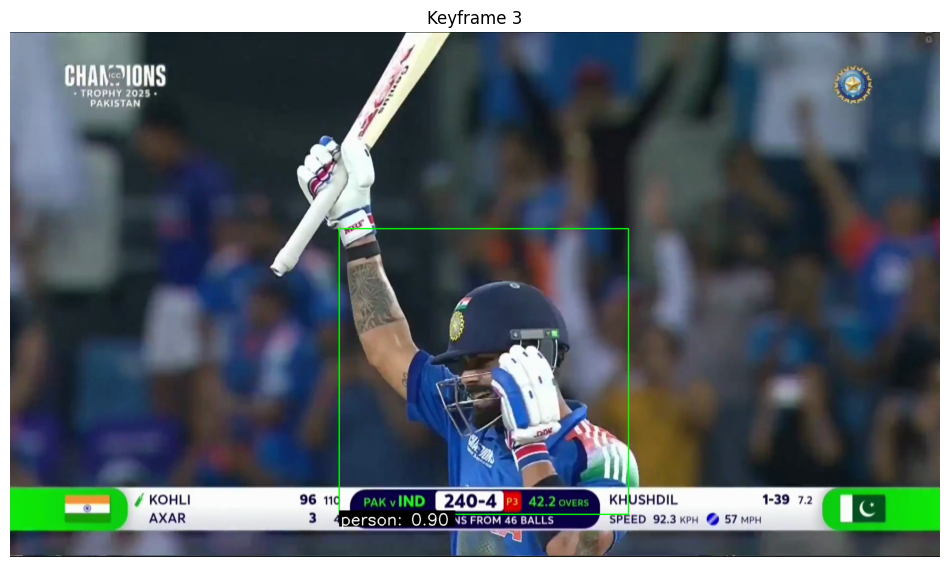

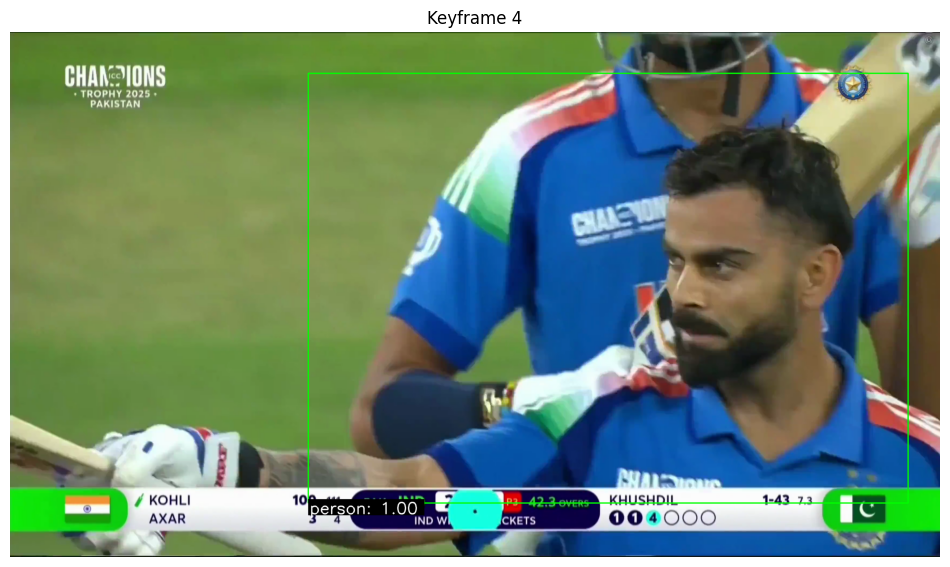

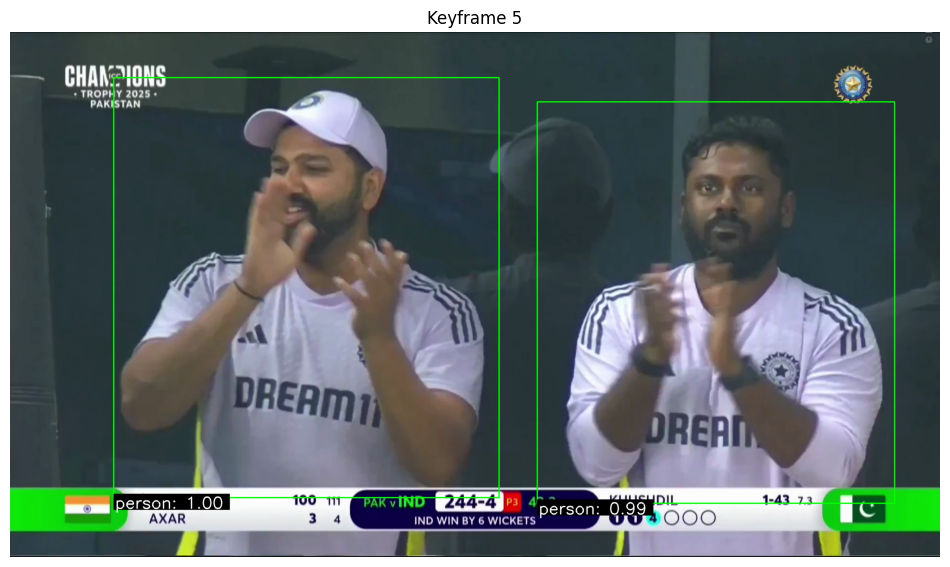

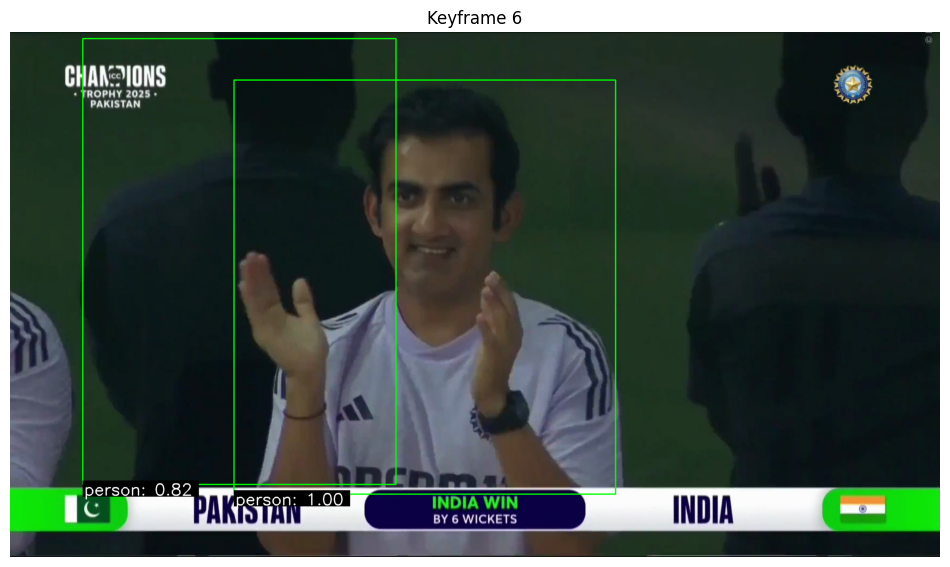

In [67]:
video_path = get_video_path()
keyframes = detect_shot_boundaries(video_path)

confidence_factor = 0.8
for idx, frame in enumerate(keyframes):
    plt.figure(figsize=(12, 8))
    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    detections = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []
    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > confidence_factor:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype("int")
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_factor, 0.4)

    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
            color = (0, 255, 0)

            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 3)

            text_y = y - 15 if y >= height // 2 else y + h + 45

            font_scale = 2
            thickness = 4
            font = cv2.FONT_HERSHEY_SIMPLEX

            text_size = cv2.getTextSize(label, font, font_scale, thickness)[0]
            text_w, text_h = text_size

            text_x = x
            text_y = max(text_y, text_h + 15)
            text_x_end = x + text_w + 25
            text_y_end = text_y - text_h - 15

            cv2.rectangle(frame, (text_x, text_y_end), (text_x_end, text_y), (0, 0, 0), -1)

            cv2.putText(frame, label, (text_x + 5, text_y - 5), font, font_scale, (255, 255, 255), thickness)

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title(f"Keyframe {idx + 1}")
    plt.show()


## High-level features: Semantic Concepts, Emotional Features, Contextual Features

Using gabor and llb filters we would be trying to detect high level features

In [28]:
def compute_lbp(image, radius=3, n_points=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def compute_gabor(image, ksize=31, sigma=4.0, lambd=10.0, gamma=0.5, psi=0, n_orientations=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.float32)
    features = []
    for theta in np.arange(0, np.pi, np.pi / n_orientations):
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
        filtered = convolve2d(gray, kernel, mode='same')
        features.append(filtered.mean())
        features.append(filtered.var())
    return np.array(features)

def compute_glcm(image, distance=1, angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(gray, distances=[distance], angles=angles, levels=levels, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    return np.array([contrast, dissimilarity, homogeneity, energy, correlation])

def plot_features(feature_vectors, feature_names):
    num_frames = len(feature_vectors)
    num_features = len(feature_names)

    plt.figure(figsize=(15, 8))
    for i in range(num_features):
        feature_values = [fv[i] for fv in feature_vectors]
        plt.plot(range(num_frames), feature_values, label=f'{feature_names[i]}')

    plt.title("Feature Values Across Keyframes")
    plt.xlabel("Keyframe Index")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [27]:
keyframes = extract_keyframes(video_path)
feature_vectors = []

for idx, frame in enumerate(keyframes):
    print(f'Started processing frame: {idx + 1}')
    lbp_hist = compute_lbp(frame)
    print(f'lbp_hist completed')
    gabor_features = compute_gabor(frame)
    print(f'gabor_features completed')
    glcm_features = compute_glcm(frame)
    print(f'glcm_features completed')
    feature_vector = np.concatenate((lbp_hist, gabor_features, glcm_features))
    print(f'feature_vector completed')
    feature_vectors.append(feature_vector)

Started processing frame: 1
lbp_hist completed
gabor_features completed
glcm_features completed
feature_vector completed
Started processing frame: 2
lbp_hist completed
gabor_features completed
glcm_features completed
feature_vector completed
Started processing frame: 3
lbp_hist completed
gabor_features completed
glcm_features completed
feature_vector completed
Started processing frame: 4
lbp_hist completed
gabor_features completed
glcm_features completed
feature_vector completed
Started processing frame: 5
lbp_hist completed
gabor_features completed
glcm_features completed
feature_vector completed


5
5


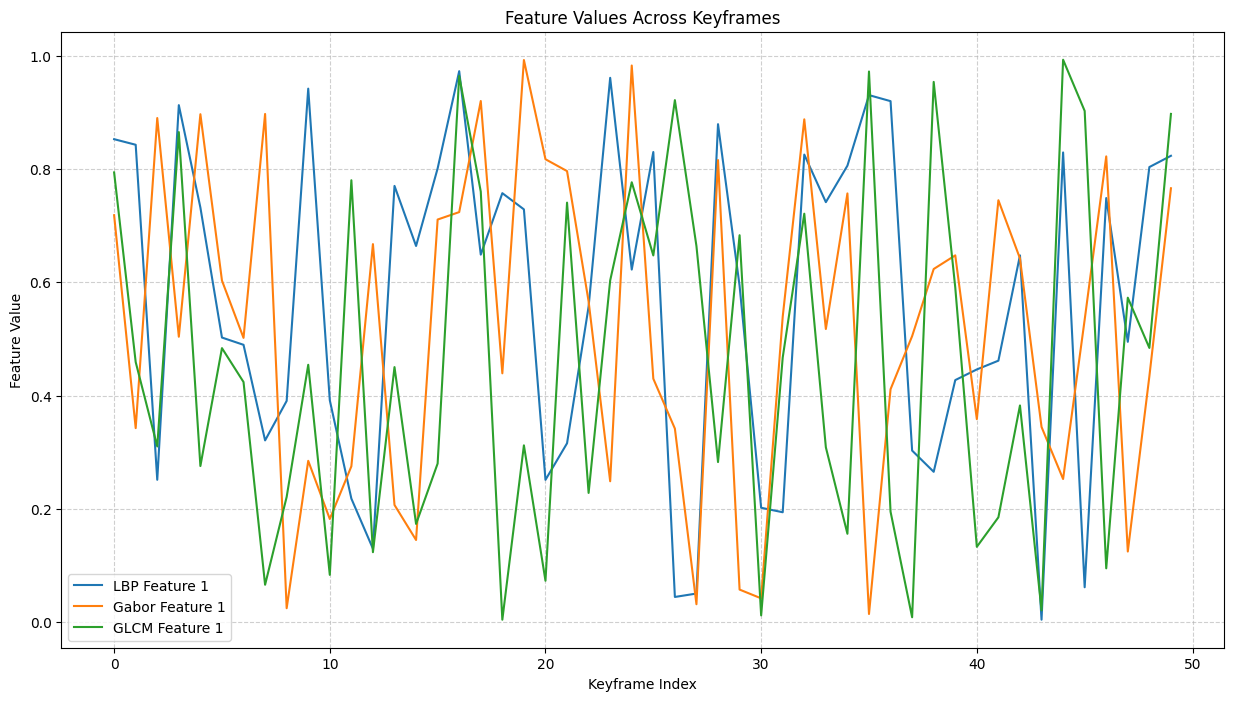

In [29]:
print(len(keyframes))
print(len(feature_vectors))

# Example usage
# Assume `feature_vectors` contains combined features from LBP, Gabor, and GLCM
# Assume `feature_names` contains corresponding names like ['LBP', 'Gabor', 'GLCM']
feature_names = ["LBP Feature 1", "Gabor Feature 1", "GLCM Feature 1"]  # Update accordingly
feature_vectors = np.random.rand(50, 3)  # Example data

plot_features(feature_vectors, feature_names)

### Additional Changes made in Webinar 2 Files
- Optimized `compute_color_coherence_vector` with downsampling and other reductions as it was taking too long to show results.
- Instead of using `imwrite` for writing to disk, immediataely showing it up using `matplotlib` function.
- With `SceneManager` library we see one additional frame compared to manual detection.
- Time logs added to see which function is taking longer while processing frames

## Webinar 3 - Motion Tracking



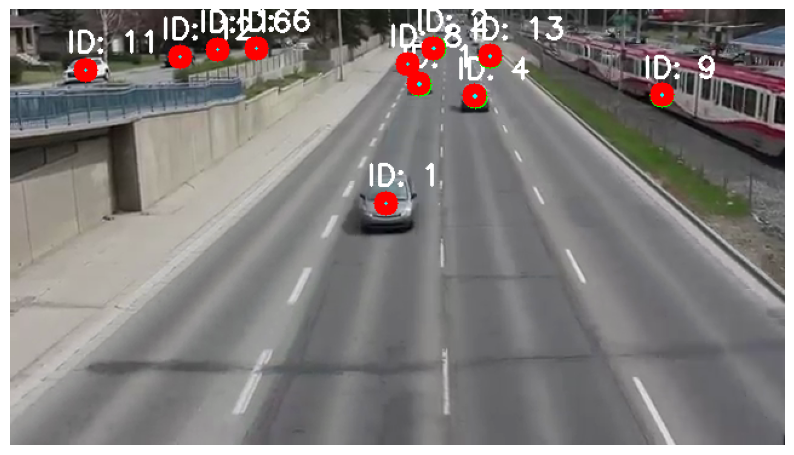

In [74]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")

kalman_filters = {}
object_ids = {}
global next_id
next_id = 0

def create_kalman_filter():
    """Creates a new Kalman filter."""
    kf = cv2.KalmanFilter(4, 2)
    kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1],
                                    [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.1
    return kf

video_path = get_video_path('traffic_cars')
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    detections = []

    for r in results:
        for box in r.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            detections.append((cx, cy))

    assigned_ids = []
    for cx, cy in detections:
        matched_id = None
        min_dist = float("inf")

        for obj_id, kf in kalman_filters.items():
            predicted = kf.predict()
            px, py = int(predicted[0]), int(predicted[1])

            dist = np.linalg.norm(np.array([px, py]) - np.array([cx, cy]))
            if dist < min_dist and obj_id not in assigned_ids:
                min_dist = dist
                matched_id = obj_id

        if matched_id is not None:
            assigned_ids.append(matched_id)
        else:
            matched_id = next_id
            kalman_filters[matched_id] = create_kalman_filter()
            object_ids[matched_id] = matched_id
            next_id += 1

        kf = kalman_filters[matched_id]
        measurement = np.array([[np.float32(cx)], [np.float32(cy)]])
        corrected = kf.correct(measurement)
        px, py = int(corrected[0]), int(corrected[1])

        cv2.circle(frame, (cx, cy), 10, (0, 255, 0), -1)
        cv2.circle(frame, (px, py), 10, (0, 0, 255), -1)
        cv2.line(frame, (px, py), (cx, cy), (255, 255, 0), 2)
        cv2.putText(frame, f"ID: {matched_id}", (cx - 15, cy - 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()

cap.release()